### Code used for Chapter 7: Comparisons. 1D DFT.

Import libraries.

The detect_peaks.py is from:
https://github.com/demotu/BMC/blob/master/functions/detect_peaks.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy import integrate
import time
import pyfftw
from numba import jit
from detect_peaks import detect_peaks
%matplotlib inline

In chapter 4, section 4.3, it was found that the order of convergence of the 2D strong-stability preserving 3rd-order Runge-Kutta with 4th-order central difference scheme does not actually preserve the intended order of convergence.

Here, a 1D strong-stability preserving 2nd-order Runge-Kutta time-stepping with 2nd-order accuracy central difference scheme is used. This is for reasons of computational cost and since the order of convergence is limited to first-order in space anyway.

For more details on the strong-stability preserving Runge-Kutta methods, see [Gottlieb et. al](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.29.497&rep=rep1&type=pdf).

The shift/roll algorithm is used here (see 2D_Strang_SSP_RK3.ipynb for more details on this algorithm).

In [3]:
import os
import sys
import h5py

class writer(object):
    
    def __init__(self,prefix,Lx,Ly,base_output_folder=None,suffix=None):
        self.prefix = prefix
        self.Lx = Lx
        self.Ly = Ly
        
        self.path = self.get_file_path(base_output_folder,suffix)

        self.groups = ['avg_conc', 'energy', 'order_parameter']
        
    def get_file_path(self, base_output_folder=None,suffix=None):
        if base_output_folder == None:
#             os.chdir(os.path.dirname(sys.argv[0]))
            os.chdir('/home/ray/git-projects/modified_ch/')
            base_output_folder = "output"
        if suffix != None:
            base_output_folder += "/" + suffix
        base_output_folder += "/"
        base_output_name = "%s_Lx=%.4f_Ly=%.4f" %(self.prefix,self.Lx,self.Ly)
#         print(base_output_name)
        hdf5_format = '.h5'
        return base_output_folder + base_output_name + hdf5_format
        
        
    def create_output_file(self, options):
#         print(self.path)
#         print(os.getcwd())

        if os.path.exists(self.path):
            os.rename(self.path, self.path+'_old')

        file = h5py.File(self.path, 'a')

        for group in self.groups:
            # check if groups have been created
            # if not created, create empty groups
            if not (group in file):
                file.create_group(group,track_order=True)

        for key in options:
            if type(options[key]) != str:
                file.attrs.create(key,options[key])
        file.close()
        
    def write_data(self, it, data):
        file = h5py.File(self.path , 'r+')
        
        for group, datum in zip(self.groups,data):
            name = group + '_%i' %it
            if isinstance(datum, (list, tuple, np.ndarray)):
                file.create_dataset(group + '/' + name, data=datum ,chunks=True, compression='gzip', compression_opts=4, dtype=np.float64)
            else:
                file.create_dataset(group + '/' + name, data=datum , dtype=np.float32)
        # print("writing time = %.1f for arrays %s" %(name,path))
        file.close()
        
    def get_dataset(self,group,it):
        file = h5py.File(self.path, 'r')
        
        arr = np.copy(file[group][group + '_' + str(it)])
        
        file.close()
        return arr

In [4]:
@jit(nopython=True)
def shifty(A,num):
    E = np.empty_like(A)
    F = np.empty_like(A)
    
    E[:num] = A[-num:]
    E[num:] = A[:-num]
    F[:-num] = A[num:]
    F[-num:] = A[:num]

    return E + F

@jit(nopython=True)
def shiftx(A,num):
    G = np.empty_like(A)
    H = np.empty_like(A)
    
    G[:,:num] = A[:,-num:]
    G[:,num:] = A[:,:-num]
    H[:,:-num] = A[:,num:]
    H[:,-num:] = A[:,:num]
    return G + H

@jit(nopython=True)
def centralDiff(A,hx,hy,delta):
    A = A**3
#     D = -1.*shift(A,2)+ 16.*shift(A,1) - 60.*A
    Dx = -1. * shiftx(A,2) + 16. * shiftx(A,1) - 30.*A
    Dx /= 12.*hx**2
    Dy = -1. * shifty(A,2) + 16. * shifty(A,1) - 30.*A
    Dy /= 12.*hy**2
    return 1./delta * (Dx+Dy)

@jit(nopython=True)
def ssp_rk2(v,hx,hy,dt,delta,m):
    v1 = v + dt * (centralDiff(v,hx,hy,delta) + m)
    v = 1./2. * v + 1./2. * v1 + 1./2. * dt * (centralDiff(v1,hx,hy,delta) + m)
    return v

def ic_hex(Nx,Ny):
    arr = np.ones((Ny,Nx)) * -0.0
    mi = 3
    mi += 0
    eix = 6
    eix += 1
    eiy = 1
    eiy += 0
    bs = 19
    br = int(bs/2)
#     print(br)

    bidx0 = (slice(0,br),slice(eix,eix+bs))
    bidx1 = (slice(-br,None),slice(eix,eix+bs))

    bidx2 = (slice(0,br),slice(-eix-bs,-eix))
    bidx3 = (slice(-br,None),slice(-eix-bs,-eix))

    bidx4 = (slice(eiy+bs+mi,eiy+mi+2*bs),slice(-br,None))
    bidx5 = (slice(eiy+bs+mi,eiy+mi+2*bs),slice(0,br))
    bidx6 = (slice(eiy+bs+mi,eiy+mi+2*bs),slice(int(Nx/2) - br,int(Nx/2) + br+1))

    ball = np.ones((19,19)) * -0.0
    xx = np.arange(-9,10)
    X,Y = np.meshgrid(xx,xx)
    r = np.sqrt(X**2 + Y**2)
#     print(r)
    ball[np.where(r <= 9.)] = 1.0
    ball_left = ball[:,:br]
    ball_right = ball[:,br+1:]
    ball_top = ball[:br,:]
    ball_bottom = ball[br+1:,:]

    arr[bidx0] = ball_bottom * 0.1
    arr[bidx1] = ball_top * 0.1
    arr[bidx2] = ball_bottom * 0.1
    arr[bidx3] = ball_top * 0.1
    arr[bidx4] = ball_left * 0.1
    arr[bidx5] = ball_right * 0.1
    arr[bidx6] = ball
    return arr

The main DFT looping. This is the 1D algorithm based on the discussions of chapter 4, however instead of the Strang-splitting, a 1st-order Lie-splitting is used (again for computational speed and the fact that the order of convergence is reduced anyway).

See *appendix E: Splitting methods* for more details on the Strang- and Lie-splittings.

In [5]:
def dft(options,wisdom=None):
    Lx = options['Lx']
    Ly = options['Ly']
    Nx = options['Nx']
    Ny = options['Ny']
    delta = options['delta']
    m = options['m']
    dt = options['dt']
    it = options['it']
    prefix = options['prefix']
    
    io = writer(prefix,Lx,Ly)
    io.create_output_file(options)
    
    # h = spatial step-size; dx = 1D spatial grid.
    hx = Lx/Nx
    hy = Ly/Ny
    dx = np.linspace(0,Lx,Nx)
    dy = np.linspace(0,Ly,Ny)
    dxy = [dx,dy]

    # lv = levels to capture average concentration and energy changes.
    it += 1
    lv = int(it/100)

    # define empty arrays for pyFFTW
    u = pyfftw.empty_aligned((Nx,Ny), dtype='complex64')
    uhatx = pyfftw.empty_aligned((Nx,Ny), dtype='complex64')
    uhaty = pyfftw.empty_aligned((Nx,Ny), dtype='complex64')
    vx = pyfftw.empty_aligned((Nx,Ny), dtype='complex64')
    vy = pyfftw.empty_aligned((Nx,Ny), dtype='complex64')
    
    uhat = pyfftw.empty_aligned((Nx,Ny), dtype='complex64')
    v = pyfftw.empty_aligned((Nx,Ny), dtype='complex64')

    # a constant.
    tpiLx = 2.*np.pi/Lx
    tpiLy = 2.*np.pi/Ly

    # initial condition
    np.random.seed(111)
    C = 1.0 # scaling factor
    r = np.random.uniform(-1.,1.,(Nx,Ny))

    # zeroing the mean of the uniform distribution.
    if r.mean()<0:
        r += r.mean()
    else:
        r -= r.mean()

    u[:,:] = m + C*r
    
#     file_ic = h5py.File('/home/ray/git-projects/modified_ch/ic_128_128.h5', 'r')

#     file_ic = h5py.File('/home/ray/git-projects/modified_ch/ic_2periods_64_64.h5', 'r')
#     file_ic = h5py.File('/home/ray/git-projects/modified_ch/rolled_ic_2periods.h5', 'r')
#     file_ic = h5py.File('/home/ray/git-projects/modified_ch/ic_2periods_nospacing.h5', 'r')
#     else:
    file_ic = h5py.File('/home/ray/git-projects/modified_ch/ic_64_64.h5', 'r')
    if Ly >= 11.0:
        r = file_ic['ic_2p'][:,:]
#     file_ic = h5py.File('/home/ray/git-projects/modified_ch/ic_test.h5', 'r')
    else:
        r = file_ic['ic'][:,:]
    
#     r = file_ic['ic'][:,:]
    u[:,:] = (m - 0.5 * r.mean()) + 0.5 * r
#     u[:,:] = (m - 0.00001 * r.mean()) + 0.00001 * r
#     file_ic.close()
    
    print(u.real.mean())
    print("IC:")
    
    plt.figure()
    plt.imshow(u.real, extent=[0,Lx,0,Ly])
    plt.colorbar()
    plt.show()
    
#     assert(0)
#     u[:,:] = ic_hex(Nx,Ny)

#     xx, _ = np.meshgrid(dx,dx)
#     u[:,:] = C*np.cos(xx)
#     u[:,:] = u - u.mean()
        
    # generate wavenumber / frequency grid.
    freqX = np.fft.fftfreq(Nx,(1.0/float(Nx))) * tpiLy
    freqY = np.fft.fftfreq(Ny,(1.0/float(Ny))) * tpiLx
    kx, ky = np.meshgrid(freqY,freqX)
    k = kx + ky
    k2 = kx**2+ky**2
    kx2 = k2
    ky2 = k2
    kx4 = k2**2
    ky4 = k2**2

#     kx2 = kx**2
#     ky2 = ky**2
    
#     kx4 = kx**4
#     ky4 = ky**4
    
    k = np.sqrt(k2)

    # empty arrays to store avg. conc. and energy.
    avgConc = np.zeros(int(it/lv+1))
    energy = np.zeros(int(it/lv+1))

    # if there is pyFFTW wisdom, import it.
    if wisdom != None:
        pyfftw.import_wisdom(wisdom)

    # define pyFFTW plans.
    fft_x = pyfftw.FFTW(u, uhatx, threads=4, axes=(0,1))
#     ifft_x = pyfftw.FFTW(vx, uhatx, direction='FFTW_BACKWARD', threads=4, axes=(0,))
    
    fft_y = pyfftw.FFTW(u, uhaty, threads=4, axes=(1,))
#     ifft_y = pyfftw.FFTW(vy, uhaty, direction='FFTW_BACKWARD', threads=4, axes=(1,))

    ifft_obj = pyfftw.FFTW(v, uhatx, direction='FFTW_BACKWARD', threads=4, axes=(0,1))

    j = 0
    t1 = 0
    t2 = 0
    
    # iterations.
    for i in range(it+1):
        # the Fourier-PS substep.
        tic1 = time.time()
        fac=0.5
#         uhatx = np.exp((-1.*delta*(kx4*(fac*tpiLx)**4 + ky4*(fac*tpiLy)**4)+(1./delta)*(kx2*(fac*tpiLx)**2 + ky2*(fac*tpiLy)**2)-1.)*dt)*fft_x(u)
#         uhatx = np.exp((-1.*delta*(kx4*fac*(tpiLx)**4 + ky4*fac*(tpiLy)**4)+(1./delta)*(kx2*fac*(tpiLx)**2 + ky2*fac*(tpiLy)**2)-1.)*dt)*fft_x(u)
        uhatx = np.exp((-1.*delta*(kx4*fac + ky4*fac) + (1./delta)*(kx2*fac + ky2*fac) -1.)*dt)*fft_x(u)
#         uhatx = np.exp((-1.*delta*((k*fac*tpiLx + k*fac*tpiLy)**4)+(1./delta)*((k*fac*tpiLx + k*fac*tpiLy)**2)-1.)*dt)*fft_x(u)
#         uhatx = np.exp((-1.*delta*kx4*tpiLx**4+(1./delta)*kx2*tpiLx**2-1.)*dt)*fft_x(u)
#         uhaty = np.exp((-1.*delta*ky4*tpiLy**4+(1./delta)*ky2*tpiLy**2-1.)*dt)*fft_y(u)
#         vx = ifft_x(uhatx).real
#         vy = ifft_y(uhaty).realuhat
#         uhat = uhatx + uhaty
        v = ifft_obj(uhatx)
#         v = vx + vy
        toc1 = time.time()
        t1 += (toc1-tic1)

        # the strong-stability preserving runge-kutta substep.
        tic2 = time.time()
        v = ssp_rk2(v,hx,hy,dt,delta,m)
        toc2 = time.time()
        t2 += (toc2-tic2)

        u[:,:] = v[:,:]

        # capture average concentration and energy of system at current level.
        if i%lv==0:
            dim = 2
            u0 = u.real
            for d in range(dim):
                dd = dxy[d]
#                 print(dd.shape)
#                 print(u0.shape)
                u0 = integrate.trapz(u0,dd,axis=0)
            avg_conc = u0 / (Lx*Ly)
            avgConc[j] = avg_conc

            T1 = -1.j * k * np.fft.fft(u)
            T1 = np.real(np.fft.ifft(T1))
            T1 = 0.5*delta*abs(T1)**2

            T2 = 1./(delta*4.)*(np.real(u)**2-1.)**2

            up = np.real(u)-m
            for d in range(dim):
                dd = dxy[d]
                up = integrate.trapz(up,dd,axis=0)
            T3 = -1.*up
            T3 = 0.5*abs(T3)**2

            en = T1 + T2 + T3
            en = np.real(en)
            for d in range(dim):
                dd = dxy[d]
                en = integrate.trapz(en,dd,axis=0)
            energy[j] = en
            j += 1
            
            data = [avg_conc, en, u.real]
            io.write_data(i, data)
            
    wisdom = pyfftw.export_wisdom()

    # normalise energy to initial energy, possible due to unitlessness of the energy.
    energy /= energy[0]
    
    print("End:")
    plt.figure()
    plt.imshow(u.real, extent=[0,Lx,0,Ly])
    plt.colorbar()
    plt.show()
    
    print("===================================\n")
    return avgConc, energy, u

Test the 1D DFT code.

Lx = 19.168028937095578
Ly = 16.6
-0.4000000065097993
IC:


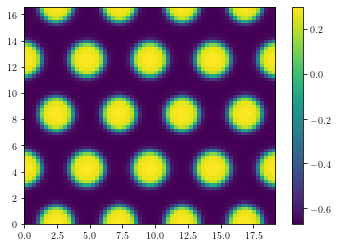

End:


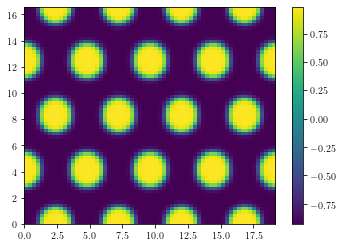


time taken: 94.266s

Lx = 19.283498990933506
Ly = 16.700000000000003
-0.4000000065097993
IC:


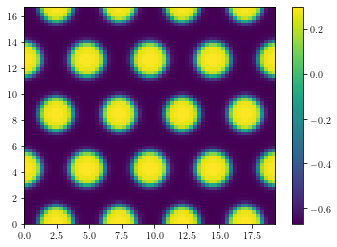

End:


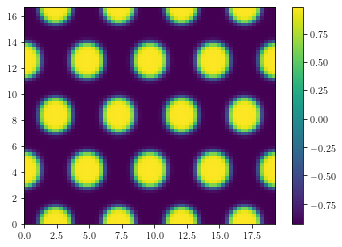


time taken: 82.105s

Lx = 19.39896904477143
Ly = 16.800000000000004
-0.4000000065097993
IC:


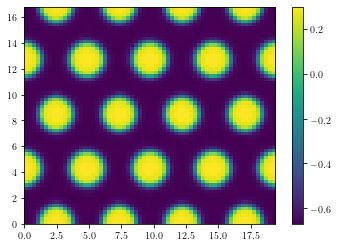

End:


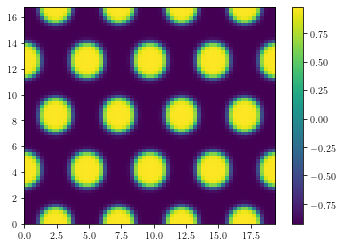


time taken: 81.922s

Lx = 19.51443909860936
Ly = 16.900000000000006
-0.4000000065097993
IC:


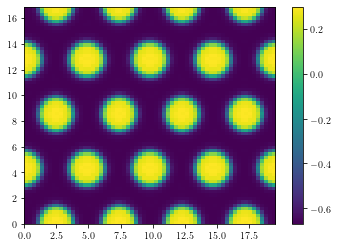

End:


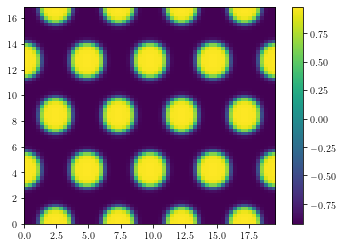


time taken: 81.325s

Lx = 19.629909152447286
Ly = 17.000000000000007
-0.4000000065097993
IC:


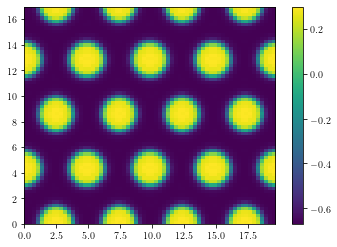

End:


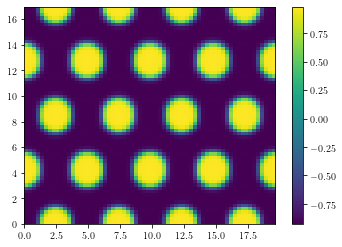


time taken: 82.019s

Lx = 19.74537920628521
Ly = 17.10000000000001
-0.4000000065097993
IC:


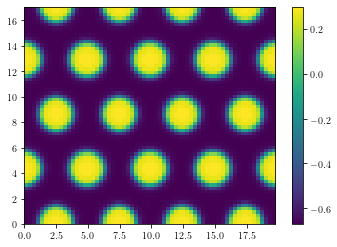

End:


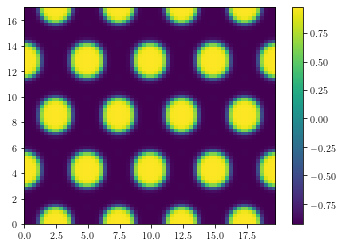


time taken: 81.752s

Lx = 19.86084926012314
Ly = 17.20000000000001
-0.4000000065097993
IC:


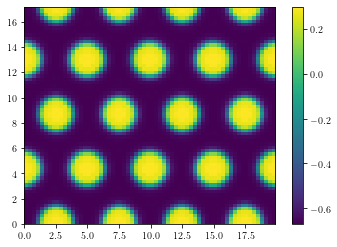

End:


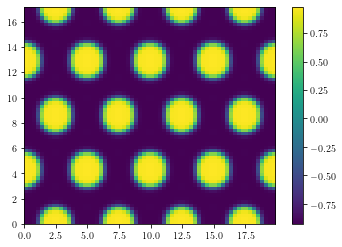


time taken: 82.375s

Lx = 19.976319313961067
Ly = 17.30000000000001
-0.4000000065097993
IC:


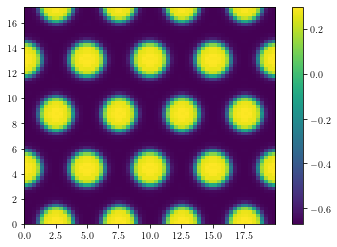

End:


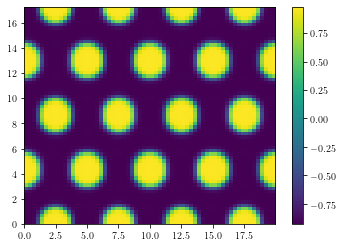


time taken: 86.651s

Lx = 20.09178936779899
Ly = 17.400000000000013
-0.4000000065097993
IC:


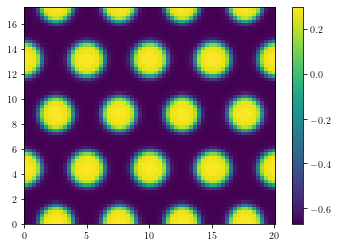

End:


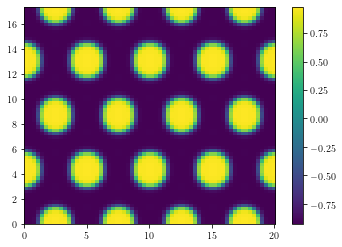


time taken: 88.709s

Lx = 20.20725942163692
Ly = 17.500000000000014
-0.4000000065097993
IC:


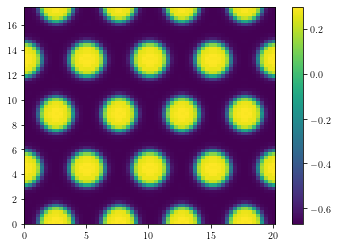

End:


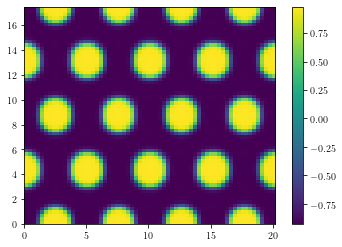


time taken: 87.203s

Lx = 20.322729475474848
Ly = 17.600000000000016
-0.4000000065097993
IC:


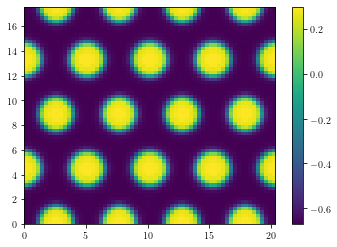

End:


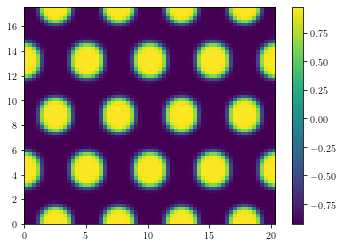


time taken: 90.538s

Lx = 20.438199529312772
Ly = 17.700000000000017
-0.4000000065097993
IC:


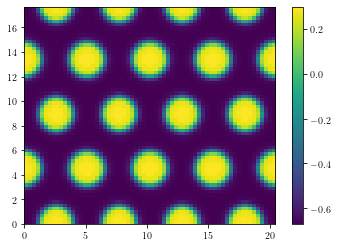

End:


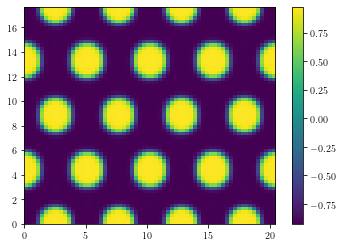


time taken: 86.072s

Lx = 20.5536695831507
Ly = 17.80000000000002
-0.4000000065097993
IC:


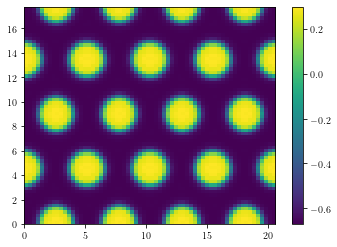

End:


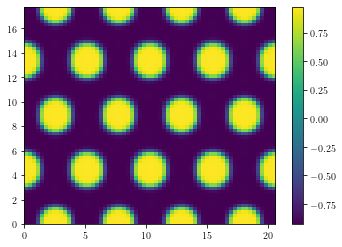


time taken: 101.637s

Lx = 20.669139636988625
Ly = 17.90000000000002
-0.4000000065097993
IC:


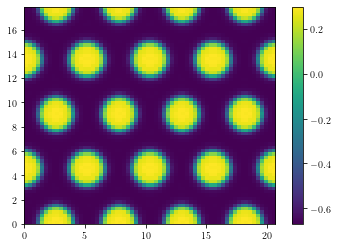

End:


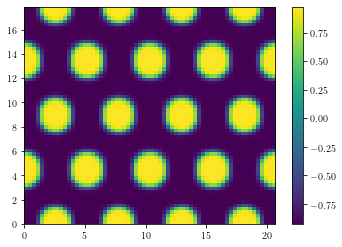


time taken: 90.824s

Lx = 20.784609690826553
Ly = 18.00000000000002
-0.4000000065097993
IC:


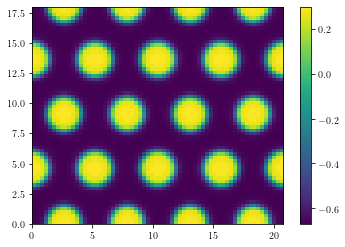

End:


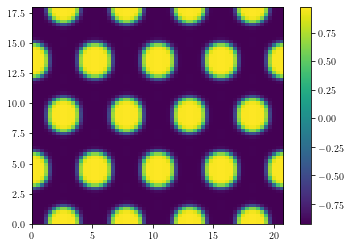


time taken: 94.609s

Lx = 20.90007974466448
Ly = 18.100000000000023
-0.4000000065097993
IC:


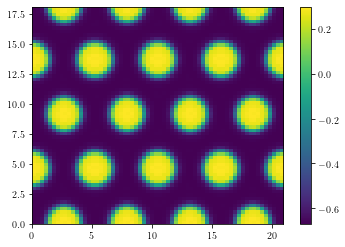

End:


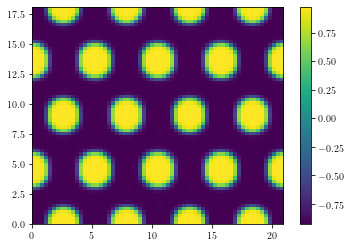


time taken: 103.968s

Lx = 21.015549798502406
Ly = 18.200000000000024
-0.4000000065097993
IC:


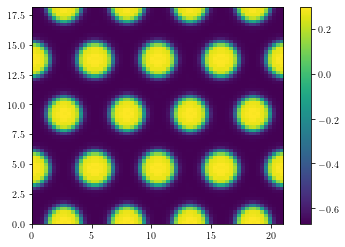

End:


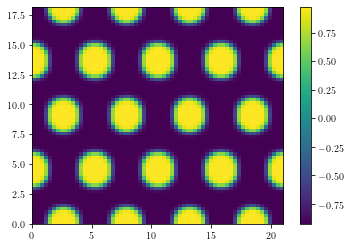


time taken: 98.741s

Lx = 21.131019852340334
Ly = 18.300000000000026
-0.4000000065097993
IC:


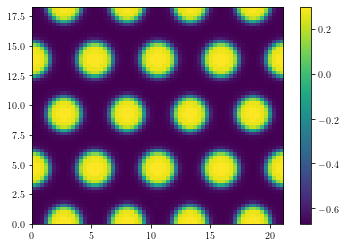

End:


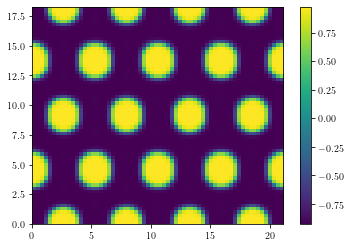


time taken: 87.336s

Lx = 21.24648990617826
Ly = 18.400000000000027
-0.4000000065097993
IC:


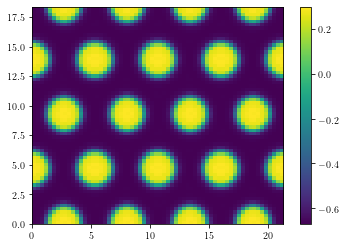

End:


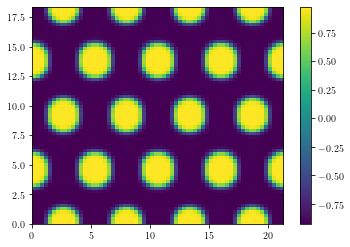


time taken: 87.016s

Lx = 21.361959960016186
Ly = 18.50000000000003
-0.4000000065097993
IC:


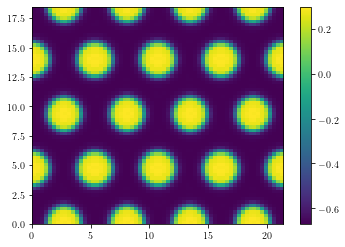

End:


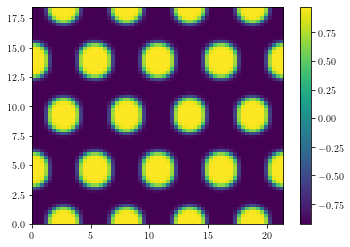


time taken: 92.764s



In [255]:
Nx = 64
Ny = 64
# Ny = 64
# Ny = int(Nx / 2 * np.sqrt(3))
# Nx = int(64/Ly * Lx)
dt = 0.0008
it = 75000

# m == ubar
m = -0.40
f = 0.3
delta = 0.16
sigma = 4./15

Lys = np.arange(16.6,18.6,0.1)
# Lys = np.array([13.5])
Lxs = Lys * 2.0 / np.sqrt(3)

Ls = [[lx,ly] for lx,ly in zip(Lxs,Lys)]

for Li in Ls:
    Lx = Li[0]
    Ly = Li[1]
    rmin = Lx * np.sqrt(f) / 4.0

    print("Lx =", Lx)
    print("Ly =", Ly)

    options = {
        'Lx' : Lx,
        'Ly' : Ly,
        'Nx' : Nx,
        'Ny' : Ny,
        'delta' : delta,
        'm' : m,
        'dt' : dt,
        'it' : it,
        'prefix' : 'dft',
        'f' : f,
        'rmin' : rmin,
        'sigma' : sigma
    }

    tic = time.time()
    avgConc, energy, u = dft(options)
    toc = time.time()

    print("time taken: %.3fs" %(toc-tic))
    print("====================\n")

In [126]:
file.close()

In [7]:
def calculate(u,Lx,Ly,Nx,Ny,delta,m=-0.4):
    def padder(f):
        return np.pad(f,(0,1),mode='wrap')
    
    def edge_mask(u):
        mask = np.ones_like(u, dtype=bool)
        mask[u.ndim * (slice(1,-1),)] = False
        return mask

    dim = 2
    
    Lxx = np.linspace(0,Lx,Nx)
    Lyy = np.linspace(0,Ly,Ny)
    dx = np.diff(Lxx)[0]
    dy = np.diff(Lyy)[0]
    dxy = [dy,dx]
    tpiLx = 2.*np.pi/Lx
    tpiLy = 2.*np.pi/Ly
    
    freqX = np.fft.fftfreq(Nx,(1.0/float(Nx))) * tpiLy
    freqY = np.fft.fftfreq(Ny,(1.0/float(Ny))) * tpiLx
    kx, ky = np.meshgrid(freqX,freqY)
    k = kx + ky
    k2 = kx**2+ky**2
    k = k2**0.5
    k2[0,0] = 1.
    
    u0 = padder(u)
    for d in range(dim):
        dd = dxy[d]
        u0 = integrate.trapz(u0,dx=dd,axis=0) * (Nx/(Nx+1))
    avg_conc = u0 / (Lx*Ly)
    
    def t1(u):
        T1 = np.fft.fft2(u)
        T1 *= -1.j * k
        T1 = np.fft.ifft2(T1)
        T1 = 0.5 * delta * (T1.real**2)
        return T1

    def t2(u):
        T2 = 1./(delta*4.)*(u**2-1.)**2
        return T2.real

    def t3(u,m):
        up = u-m
        up0 = np.copy(up)

        upp = np.fft.fft2(up)
        upp /= k2
        up = np.fft.ifft2(upp).real
        
        T3 = 0.5 * up * up0
        return T3.real

    T1 = t1(u)
    T2 = t2(u)
    T3 = t3(u,m)
    
    T1l = np.copy(T1)
    T2l = np.copy(T2)
    T3l = np.copy(T3)

#     T1l = np.copy(T1).sum()
#     T2l = np.copy(T2).sum()
#     T3l = np.copy(T3).sum()

    T1l = padder(T1l)
    T2l = padder(T2l)
    T3l = padder(T3l)
    
#     T1l[edge_mask(T1l)] *= 0.5
#     T2l[edge_mask(T2l)] *= 0.5
#     T3l[edge_mask(T3l)] *= 0.5
    
    for d in range(dim):
        dd = dxy[d]
        T1l = np.trapz(T1l,dx=dd)
        T2l = np.trapz(T2l,dx=dd)
        T3l = np.trapz(T3l,dx=dd)
        
#         T1l = integrate.trapz(T1l,dd,axis=0)
#         T2l = integrate.trapz(T2l,dd,axis=0)
#         T3l = integrate.trapz(T3l,dd,axis=0)
    
#     T3l = T3l * (Lx * Ly)

    en = T1l + T2l + T3l
#     en = padder(en)
#     for d in range(dim):
#         dd = dxy[d]
#         en = np.trapz(en,dx=dd,axis=0) * (Nx/(Nx+1))

    return en, avg_conc, np.array([T1l,T2l,T3l])

Lys =  [ 6.    6.4   6.8   7.    7.1   7.2   7.3   7.35  7.4   7.45  7.5   7.6
  7.7   7.8   7.9   8.    8.4   8.8   9.2   9.6  10.   10.4  10.8  11.2
 11.6  12.   12.4  12.8  13.2  13.6  14.   14.   14.1  14.2  14.3  14.4
 14.5  14.6  14.7  14.75 14.8  14.9  15.   15.2  15.6  16.   16.4  16.8
 17.2  17.6  18.  ]


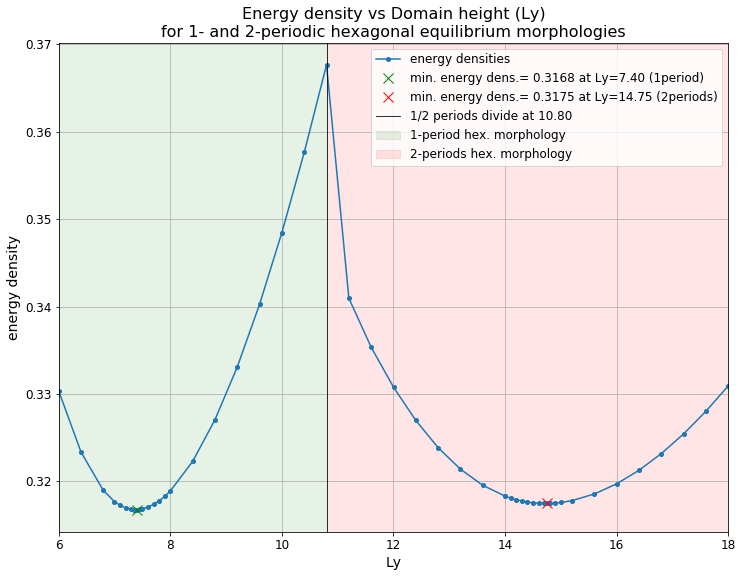

Minimum Ly = [7.4]
Maximum Ly = [10.8]
0.31678, 0.31748
['(6.00,, 0.3304)', '(6.40,, 0.3234)', '(6.80,, 0.3190)', '(7.00,, 0.3177)', '(7.10,, 0.3173)', '(7.20,, 0.3170)', '(7.30,, 0.3168)', '(7.35,, 0.3168)', '(7.40,, 0.3168)', '(7.45,, 0.3168)', '(7.50,, 0.3169)', '(7.60,, 0.3171)', '(7.70,, 0.3174)', '(7.80,, 0.3178)', '(7.90,, 0.3183)', '(8.00,, 0.3189)', '(8.40,, 0.3223)', '(8.80,, 0.3271)', '(9.20,, 0.3331)', '(9.60,, 0.3403)', '(10.00,, 0.3485)', '(10.40,, 0.3576)', '(10.80,, 0.3676)', '(11.20,, 0.3410)', '(11.60,, 0.3353)', '(12.00,, 0.3308)', '(12.40,, 0.3270)', '(12.80,, 0.3239)', '(13.20,, 0.3214)', '(13.60,, 0.3196)', '(14.00,, 0.3183)', '(14.00,, 0.3183)', '(14.10,, 0.3181)', '(14.20,, 0.3179)', '(14.30,, 0.3178)', '(14.40,, 0.3176)', '(14.50,, 0.3176)', '(14.60,, 0.3175)', '(14.70,, 0.3175)', '(14.75,, 0.3175)', '(14.80,, 0.3175)', '(14.90,, 0.3175)', '(15.00,, 0.3176)', '(15.20,, 0.3178)', '(15.60,, 0.3186)', '(16.00,, 0.3197)', '(16.40,, 0.3213)', '(16.80,, 0.3232)', '(1

In [42]:
from skimage.transform import resize

# Lys = np.arange(6.91,7.10,0.01)
# print(Ly)
f = 0.3
Lys = np.arange(6.0,18.2,0.4)

ext0 = np.arange(7.0,8.0,0.1)
ext0 = np.delete(ext0,[2,6])
Lys = np.concatenate((Lys,ext0))

ext1 = np.arange(14.0,15.1,0.1)
ext1 = np.delete(ext1,[4,8])
Lys = np.concatenate((Lys,ext1))

Lys = np.concatenate((Lys,[7.35,7.45,14.75]))

Lys.sort(kind='mergesort')
# Lys = np.delete(Lys,np.where(np.isclose(Lys,[14.8])))

print("Lys = ", Lys)

# Lys = np.arange(6.1,7.0,0.1)
# Lys = np.arange(6.0,15.0,0.1)
# Lys = np.array([9.4])
# Lys = Lys = np.arange(6.15,6.26,0.01)
# Lys = np.arange(6.0,6.16,0.01)
Lxs = Lys * 2.0 / np.sqrt(3)
Nx = 256
Ny = Nx

Ls = [[lx,ly] for lx,ly in zip(Lxs,Lys)]

prefix = 'dft'
folder = ''
# dataset = 'ic'
dataset = 'energy'
# it = 50000
it = 200000
it = 75000
# it = 60000
delta = 0.16

dataset_name0 = "%s_%i" %(dataset,0)
dataset_name = "%s_%i" %(dataset,it)

energies = []
concs = []
rmins = Lxs * np.sqrt(f) / 4.0

for Li in Ls:
    Lx = Li[0]
    Ly = Li[1]
#     Nx, Ny = 64, 64
    
#     if Ly >= 11.1:
#         it = 100000
    
#     l = Lx/2.0
#     print(Ly)
    
    io = writer(prefix,Lx,Ly,suffix=folder)
    file = h5py.File(io.path)
#     print(io.path)
    u = file[dataset][dataset_name][...]
#     u0 = file[dataset][dataset_name0][...]
#     print(u)
#     energy = file[dataset][dataset_name][...]

#     Nx, Ny = 256,256
#     u = resize(u,(Nx,Ny))
    
    energy, avg_conc, Ts = calculate(u,Lx,Ly,Nx,Ny,delta)

    energy /= (Lx * Ly)
    energies.append(np.array(energy))
    concs.append(avg_conc)
    
    file.close()

energies = np.array(energies)

energy_min = energies.min()
Lys_1p, energies_1p = Lys[np.where(Lys < 11.0)], energies[np.where(Lys < 11.0)]
Lys_min_1p = Lys_1p[np.where(energies_1p==energies_1p.min())]

Lys_2p, energies_2p = Lys[np.where(Lys >= 11.0)], energies[np.where(Lys >= 11.0)]
Lys_min_2p = Lys_2p[np.where(energies_2p==energies_2p.min())]

energy_max = energies.max()
Lys_max = Lys[np.where(energies==energies.max())]


fig = plt.figure(figsize=(12,9))
ax = plt.gca()
plt.plot(Lys,energies, 'o-', ms='4', label="energy densities")
plt.plot(Lys_min_1p,energies_1p.min(), 'gx', ms='10', label="min. energy dens.= %.4f at Ly=%.2f (1period)" %(energies_1p.min(),Lys_min_1p))
# plt.plot(Lys_min,energy_min, 'rx', ms='10', label="min. energy dens. for 1 periods at Ly=%.1f" %Lys_min)
plt.plot(Lys_min_2p,energies_2p.min(), 'rx', ms='10', label="min. energy dens.= %.4f at Ly=%.2f (2periods)" %(energies_2p.min(),Lys_min_2p))

# plt.plot(Lys_max,energy_max, 'gx', label="max. rel. energy at Ly=%.1f" %Lys_max)
divider = Lys[np.where(energies==energies.max())]

plt.axvspan(5., divider, color='g', alpha=0.1, label='1-period hex. morphology')
plt.axvspan(divider,19.5, color='r', alpha=0.1, label='2-periods hex. morphology')

# plt.axvline(x = 15.0, c='g', lw=0.8, label=r'1-period min. $\approx$ 0.3317')
# plt.axhline(y = energies.min(), c='r', lw=0.8, label=r'2-period min. $\approx$ 0.3256')

plt.axvline(x = Lys[np.where(energies==energies.max())], c='k', lw=0.8, label="1/2 periods divide at %.2f" %(divider))

plt.ylabel("energy density", fontsize=14)
plt.xlabel("Ly", fontsize=14)
plt.xlim([Lys[0],Lys[-1]])
# plt.ylim([0.30,0.40])
plt.legend(fontsize=12)
ax.tick_params(labelsize=12)
plt.grid()
plt.title("Energy density vs Domain height (Ly)\nfor 1- and 2-periodic hexagonal equilibrium morphologies", fontsize=16)
plt.show()

# print(energies)
print("Minimum Ly =", Lys[np.where(energies==energies.min())])
print("Maximum Ly =", Lys[np.where(energies==energies.max())])
print("%.5f, %.5f" %(energies_1p.min(), energies_2p.min()))
# print(np.isclose(Lys,[16.5]) * energies)
# print(concs)
print(["(%.2f,, %.4f)" %(i,j) for (i,j) in list(zip(Lys,energies))])
# print(Lys[np.where(energies==0.24413937)])

In [125]:
Lys = np.arange(7.0,8.0,0.1)
Lys = np.delete(Lys,[4,8])
print(Lys)

Lys = np.arange(14.0,15.0,0.1)
Lys = np.delete(Lys,[4,8])
Lys = np.concatenate((Lys,[7.4,7.8]))
Lys.sort(kind='mergesort')
print(Lys)

[7.  7.1 7.2 7.3 7.5 7.6 7.7 7.9]
[ 7.4  7.8 14.  14.1 14.2 14.3 14.5 14.6 14.7 14.9]


Lx = 18.8216187755818
Ly = 16.3
shift 0
-------------
terms = [1.67464765e-31 7.47256009e+01 3.38824549e+01]
energy density = 0.3432027007796291
concentration = -0.4003554835461892


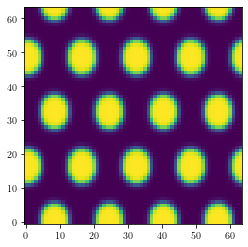

shift 1
-------------
terms = [2.59060596e-31 7.47256009e+01 3.38824549e+01]
energy density = 0.3432027007796291
concentration = -0.4003554835461892


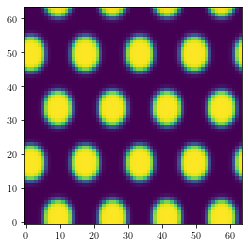

shift 2
-------------
terms = [2.26389469e-31 7.47256009e+01 3.38824549e+01]
energy density = 0.3432027007796291
concentration = -0.4003554835461892


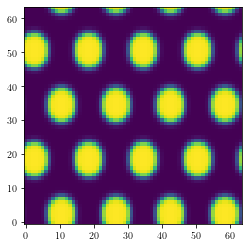

shift 3
-------------
terms = [2.31256843e-31 7.47256009e+01 3.38824549e+01]
energy density = 0.3432027007796291
concentration = -0.4003554835461892


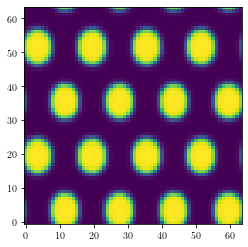

shift 4
-------------
terms = [2.16681314e-31 7.47256009e+01 3.38824549e+01]
energy density = 0.3432027007796291
concentration = -0.4003554835461892


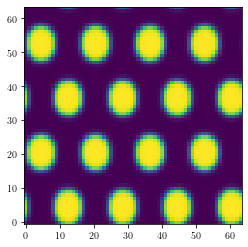

shift 5
-------------
terms = [2.68768723e-31 7.47256009e+01 3.38824549e+01]
energy density = 0.3432027007796291
concentration = -0.4003554835461892


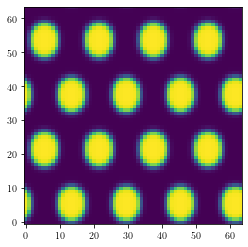

shift 6
-------------
terms = [2.46376879e-31 7.47256009e+01 3.38824549e+01]
energy density = 0.3432027007796291
concentration = -0.4003554835461892


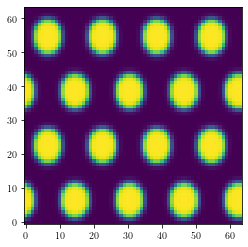

shift 7
-------------
terms = [3.35714643e-31 7.47256009e+01 3.38824549e+01]
energy density = 0.3432027007796291
concentration = -0.4003554835461892


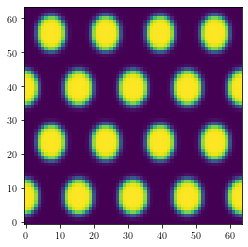

shift 8
-------------
terms = [1.71212491e-31 7.47256009e+01 3.38824549e+01]
energy density = 0.3432027007796291
concentration = -0.4003554835461892


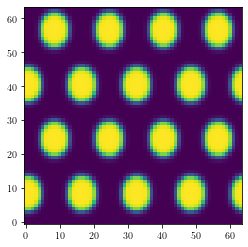

shift 9
-------------
terms = [2.66726353e-31 7.47256009e+01 3.38824549e+01]
energy density = 0.3432027007796291
concentration = -0.4003554835461892


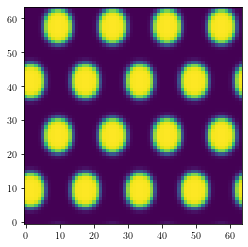

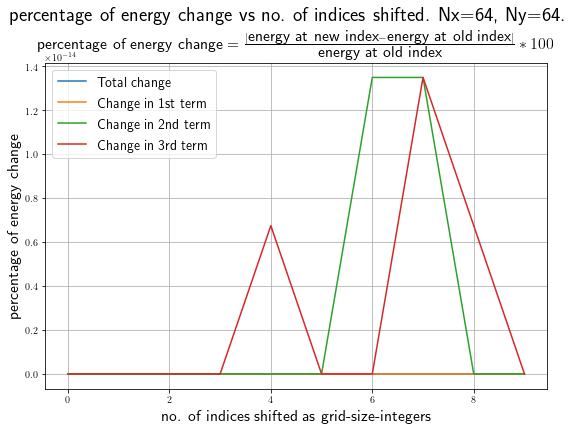

R = 3.1251002491510596


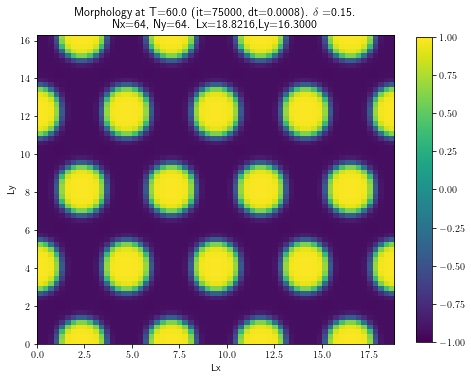

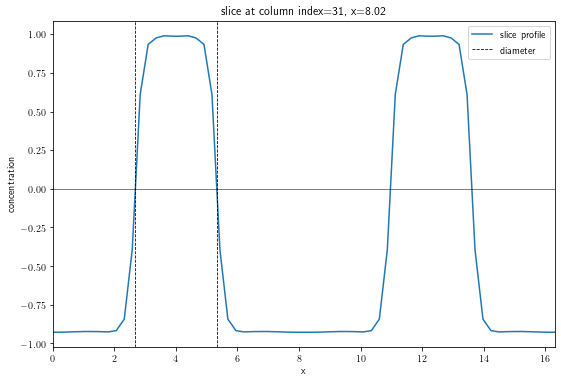

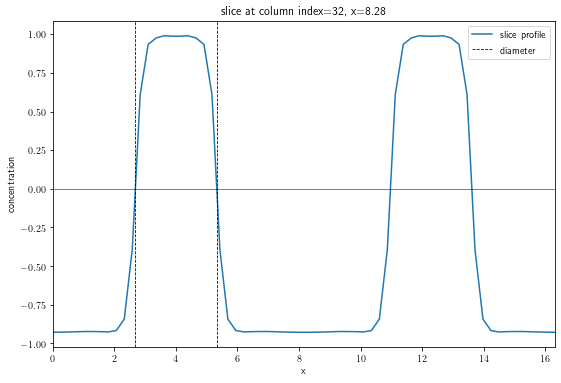

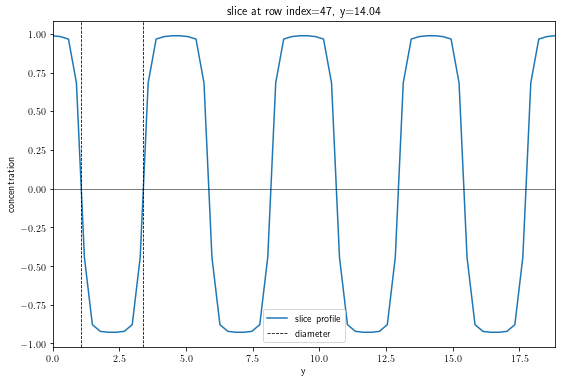

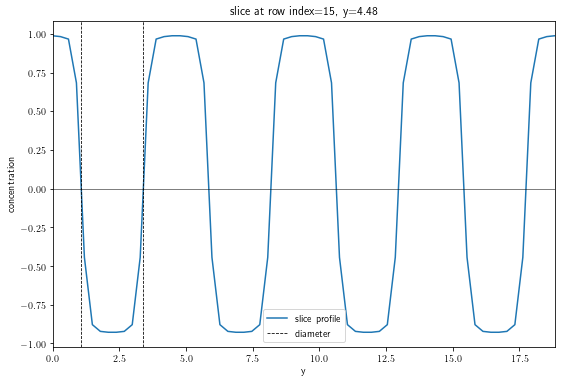

1.2424205915619362


In [499]:
Ly = 16.3
Lx = Ly * 2.0 / np.sqrt(3)
print("Lx =", Lx)
print("Ly =", Ly)

dataset = 'order_parameter'
# folder = 'delta=0.15'
it = 100000
it = 75000
dt = 0.0008
delta = 0.15
# folder = '128_128_fixed_ic'
folder = ''
# folder = 'rolled_ic_delta=0.13_010220'
dataset_it = '%s_%i' %(dataset,it)
Nx = 64
Ny = Nx
delta = 0.15

io = writer(prefix,Lx,Ly,suffix=folder)
file = h5py.File(io.path)

u = file[dataset][dataset_it][...]
# print(file['energy']['energy_%i' %it][...] / file['energy']['energy_0'][...])
u0 = np.copy(u)

pchange, t1pc, t2pc, t3pc = [], [], [], []

def pdiff(curr,old,en_old):
    return np.abs(curr - old) / en_old * 100.

for ii in range(10):
    print("shift %i" %ii)
    print("-------------")
    
    u = np.roll(u, 1 ,axis=0)
    u = np.roll(u, 1 ,axis=1)
    en, conc, Ts = calculate(u,Lx,Ly,Nx,Ny,delta)
    
    print("terms =", Ts)
    print("energy density =", en / (Lx*Ly))
    print("concentration =", conc)
    
    if ii == 0: en_old = en
    if ii == 0: t1_old, t2_old, t3_old = Ts[0], Ts[1], Ts[2]
    
    t1pc.append(pdiff(Ts[0],t1_old,en_old))
    t2pc.append(pdiff(Ts[1],t2_old,en_old))
    t3pc.append(pdiff(Ts[2],t3_old,en_old))
    pchange.append(pdiff(en,en_old,en_old))
    en_old, t1_old, t2_old, t3_old = np.copy(en), Ts[0], Ts[1], Ts[2]
    
    fig = plt.figure()
    plt.imshow(u, origin="lower")
    plt.show()
    
# output = h5py.File('ic_test.h5')
# output.create_dataset('/ic', data=u.real , dtype=np.float32)
# output.close()
    
from matplotlib import rc
rc('text', usetex=True)
fig = plt.figure(figsize=(9,6))
plt.plot(pchange, label="Total change")
plt.plot(t1pc, label="Change in 1st term")
plt.plot(t2pc, label="Change in 2nd term")
plt.plot(t3pc, label="Change in 3rd term")
plt.grid()
plt.legend(fontsize=14)
plt.xlabel("no. of indices shifted as grid-size-integers", fontsize='16')
plt.ylabel("percentage of energy change", fontsize='16')
# plt.title(r'$\text{percentage of energy change} =$')
# plt.title(r'$\frac{\lvert \\text{energy at new index} - \\text{energy at old index} \rvert}{\\text{energy at old index}}$')
# plt.title(r'$\vert \frac{\textmd{sigma  text}}{\textmd{sigma}} \vert$')
plt.suptitle(r'percentage of energy change vs no. of indices shifted. Nx=%i, Ny=%i.' %(Nx,Ny), fontsize='20', y=1.01)
plt.title(r'$\textmd{percentage of energy change} = \frac{\vert \textmd{energy at new index} - \textmd{energy at old index} \vert}{\textmd{energy at old index}} * 100$', fontsize='16')
plt.show()

u = u0

lx = np.linspace(0,Lx,Nx)
ly = np.linspace(0,Ly,Ny)

curr = -np.inf
cnt = 0
curr_idx = -np.inf
idxs = []
for row in u.T:
    if row.sum() > curr:
        curr = row.sum()
        curr_idx = cnt
    cnt += 1
    
weights_x = u.sum(axis=0)
weights_x_idx = np.argsort(weights_x)
weights_x = np.sort(weights_x)[::-1]
weights_x_idx = weights_x_idx[::-1]

weights_y = u.sum(axis=1)
weights_y_idx = np.argsort(weights_y)
weights_y = np.sort(weights_y)[::-1]
weights_y_idx = weights_y_idx[::-1]

# print(weights_x_idx)
# print(weights_y_idx)

x1 = 9
x2 = 0
# x1 = np.where(weights_x_idx == 14)
# x2 = np.where(weights_x_idx == 46)
y1 = 3
y2 = 1
    
f = 0.3
sigma = 4./15
sigma = 2./(3*np.sqrt(2))
rmin = ( (16. * sigma) / (f - np.log(f)) )**(1/3)
R = rmin / np.sqrt(f)
print("R =", R)

fig = plt.figure(figsize=(8,8))
ax = plt.gca()
plt.imshow(u, extent=[0,Lx,0,Ly], origin='lower', vmin=-1., vmax=1.)
# plt.imshow(u.T)
plt.colorbar(shrink=.7)
# plt.minorticks_on()
# plt.grid(which='major',ls='-')
# plt.grid(which='minor',ls='--')
plt.xlabel("Lx")
plt.ylabel("Ly")
# plt.axvline(x=lx[curr_idx],c='r',lw=1.0,ls='--',label='slice location')
# plt.axvline(x=lx[weights_x_idx[x1]],c='r',lw=1.0,ls='--',label='slices with max. diameter of 1st ball')
# plt.axvline(x=lx[weights_x_idx[x2]],c='k',lw=1.0,ls='--',label='slices with max. diameter of 2nd ball')

# plt.axhline(y=ly[weights_y_idx[y1]],c='r',lw=1.0,ls='--')
# plt.axhline(y=ly[weights_y_idx[y2]],c='k',lw=1.0,ls='--')
# circle0 = plt.Circle((lx[weights_x_idx[x1]],ly[weights_y_idx[y1]]),R, fill=False, color='white', label='radius R')
# circle1 = plt.Circle((lx[weights_x_idx[x2]],ly[weights_y_idx[y2]]),R, fill=False, color='white')
# ax.add_patch(circle0)
# ax.add_artist(circle1)
# ax.legend([circle0], ['radius R'])

plt.title("Morphology at T=%.1f (it=%i, dt=%.4f). $\delta=$%.2f.\nNx=%i, Ny=%i. Lx=%.4f,Ly=%.4f" %(it*dt,it,dt,delta,Nx,Ny,Lx,Ly))
# plt.legend()
plt.show()

# print(lx[weights_x_idx[x1]],ly[weights_y_idx[y1]])
# print(lx[weights_x_idx[x2]],ly[weights_y_idx[y2]])

# print( ((lx[weights_x_idx[x1]] - lx[weights_x_idx[x2]])**2 + (ly[weights_y_idx[y1]] - ly[weights_y_idx[y2]])**2)**0.5)

from scipy import interpolate
def get_radius(u,idx,l,L,axs):
    if axs=='x':
        slc = u.T[idx]
        txt = 'column'
    elif axs=='y':
        slc = u[idx]
        txt = 'row'
    else:
        assert(0)
        
    tck = interpolate.splrep(l, slc, s=0)
    ls = interpolate.sproot(tck)
    length = min(ls[1] - ls[0], ls[0] + (L - ls[1]))
    
    plt.figure(figsize=(9,6))
    plt.plot(l,slc,label='slice profile')
    plt.axhline(y=0,ls='-',lw=0.5,c='k')
    plt.title("slice at %s index=%i, %s=%.2f" %(txt,idx,axs,l[idx]))
    plt.ylabel("concentration")
    plt.xlabel("%s" %axs)
    plt.axvline(x=ls[0], lw=0.8, ls='dashed', c='k', label='diameter')
    plt.axvline(x=ls[1], lw=0.8, ls='dashed', c='k')#, label='right diameter')
    plt.xlim([0,L])
    plt.legend()
    plt.show()
    return length / 2, ls
    
# print(x1[0][0])
r1,ls1 = get_radius(u,weights_x_idx[0],ly,Ly,'x')
r2,ls2 = get_radius(u,weights_x_idx[1],ly,Ly,'x')
r3,ls3 = get_radius(u,weights_y_idx[0],lx,Lx,'y')
r4,ls4 = get_radius(u,weights_y_idx[1],lx,Lx,'y')

# print([r1,r2,r3,r4])
print(np.mean([r1,r2,r3,r4]))

file.close()

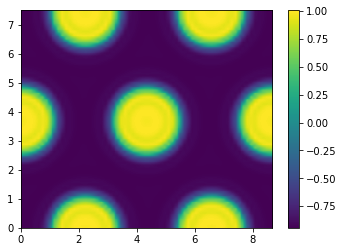

-0.40027127
0.3472141316304479
22.55222
[8.5753410e-12 1.6502163e+01 6.0500569e+00] -0.40028349157811155


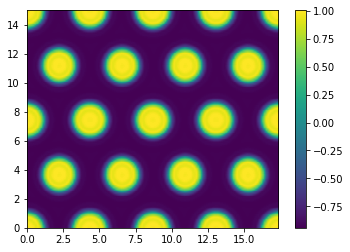

-0.40027124
0.3492174203070962
diff = 0.002003288676648285
en/4 = 22.682337
[5.4792828e-12 6.6562592e+01 2.4166756e+01] -0.40028346232682116


In [78]:
file = h5py.File('/home/ray/git-projects/modified_ch/ic_64_64.h5', 'r+')
u = file['ic'][:,:]
file.close()

from scipy import signal
from scipy import ndimage
from skimage.transform import resize

m = -0.4

Nx, Ny = 256,256
Ly = 7.5
Lx = Ly * 2.0 / np.sqrt(3)
# print("Lx1 = ", Lx)
delta = 0.15

u = resize(u,(Nx,Ny))
en, conc, Ts = calculate(u,Lx,Ly,Nx,Ny,delta,m)

plt.figure()
# u = np.roll(u,16,axis=0)
plt.imshow(u, origin="lower", extent=[0,Lx,0,Ly])
# u[:,:] = (m - 0.5 * u.mean()) + 0.5 * u
plt.colorbar()
plt.show()
print(u.mean())
en0 = en / (Lx * Ly)
print(en / (Lx * Ly))
print(en)
print(Ts, conc)

# u = u2
plt.figure()
# u = np.roll(u,32,axis=0)
u = np.pad(u,(int(Nx/2),int(Ny/2)),mode='wrap')
u = resize(u,(Nx,Ny))

Ly = 15.0
Lx = Ly * 2.0 / np.sqrt(3)

plt.imshow(u, origin="lower",extent=[0,Lx,0,Ly])
plt.colorbar()
plt.show()


# delta = 0.15
en, conc, Ts = calculate(u,Lx,Ly,Nx,Ny,delta)
# en, conc, Ts = calculate(u,Lx,Ly,Nx,Ny,delta,m=conc)
print(u.mean())
print(en / (Lx * Ly))
print("diff =", en / (Lx * Ly) - en0)
print("en/4 = %.6f" %(en/4))
print(Ts, conc)
# file.create_dataset('/ic_2p', data=u , dtype=np.float32)

file.close()

In [41]:
np.arange(6.0,18.1,0.4)

array([ 6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. ,
       10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8, 13.2, 13.6, 14. , 14.4,
       14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2, 17.6, 18. ])

In [25]:
1.6502163e+01*4

66.008652

In [118]:
ll = np.arange(6.0,15.1,0.1)
print(ll.shape)
print(ll)

(91,)
[ 6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3
  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7
  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1
 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5
 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9
 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3
 14.4 14.5 14.6 14.7 14.8 14.9 15. ]


In [391]:
Ly = 7.5
Lx = Ly * 2.0 / np.sqrt(3.0)

A = Lx*Ly
print(A)
A2 = A * 2
y2 = A2 * np.sqrt(3.0) / 2.0
Ly0 = np.sqrt(y2)
print(Ly0)
Lx0 = Ly0 * 2.0 / np.sqrt(3.0)
print(Lx0)
A2 = Lx0 * Ly0

print(A2)
print(A2/2)

64.9519052838329
10.606601717798213
12.247448713915892
129.90381056766583
64.95190528383291
